In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Transformer
It's time.

### Encoder Block
Attention block with a FFN/MLP and add-norm.

In [31]:
from naml.modules import torch
from naml.modules.transformer import EncoderBlock

X = torch.ones((2,100,24))
lens = torch.tensor([3,2])
blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48,8, 0.5)
blk.eval()
Y_enc = blk.forward(X, lens)

### Encoder
Stack of encoder blocks with positional encoding.

In [32]:
from naml.modules.transformer import Encoder

encoder = Encoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 2)
encoder.eval()
Y_enc, K_states = encoder.forward(torch.ones((2,100)).long(), lens)
Y_enc.shape

torch.Size([2, 100, 24])

### Decoder Block/Decoder
Attention block with a FFN/MLP and add-norm.

To ensure self regressive property, the decoder block has an additional attention block that attends to the encoder output.

In [33]:
from naml.modules.transformer import DecoderBlock
blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
blk.eval()
X = torch.ones((2,100,24))
Y_dec, K = blk.forward(X, Y_enc, lens, None)
Y_dec.shape

torch.Size([2, 100, 24])

### Training
We'll use `seq2seq` training code again.

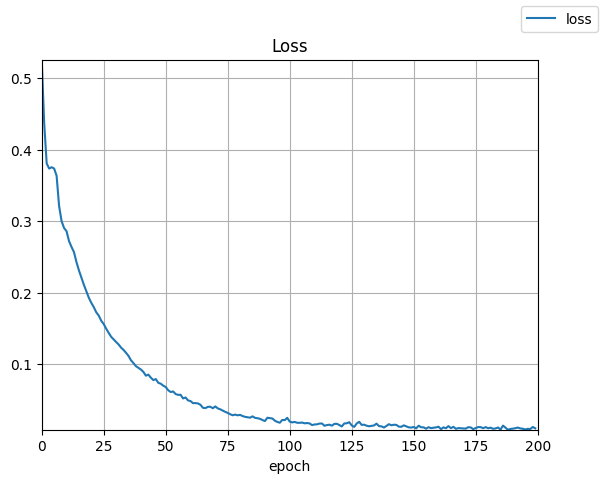

Loss:   0%|          | 0/200 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

In [34]:
from naml.modules.transformer import Encoder, Decoder, EncoderDecoder
n_hidden, num_layers, dropout_p, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, epochs = 0.005, 200
ffn_n_in, ffn_n_hidden, n_heads = 32, 64, 4
n_keys, n_query, n_values = 32, 32, 32
norm_shape = [32]

from naml.text import flatten, Vocabulary
from naml.dataset import Datasets
from naml.dataset.nmt import load_nmt
datasets = Datasets("~/naml-data")
src_words, target_words = load_nmt(datasets, 'cmn', 'eng', max_examples=500)
src_vocab, tgt_vocab = Vocabulary(flatten(src_words)), Vocabulary(flatten(target_words))

encoder = Encoder(len(src_vocab), n_keys, n_query, n_values, n_hidden, norm_shape, ffn_n_in, ffn_n_hidden, n_heads, dropout_p, num_layers)
decoder = Decoder(len(tgt_vocab), n_keys, n_query, n_values, n_hidden, norm_shape, ffn_n_in, ffn_n_hidden, n_heads, dropout_p, num_layers)
net = EncoderDecoder(encoder, decoder)

from naml.modules.sequence import train_seq2seq

train_seq2seq(net, lr, epochs, src_vocab, tgt_vocab, src_words, target_words, batch_size, num_steps)

## Prediction
Same code again. Used in `seq2seq` & `Bahdanau`

In [35]:
from naml.dataset.nmt import nmt_tokenizer
from naml.modules.sequence import predict_seq2seq
from naml.sequence import bleu
def from_src_string(src : str):
    src_indices = nmt_tokenizer(src.lower())
    src_indices = src_vocab.to_indices(src_indices)    
    src_indices = src_vocab.truncate_pad(src_indices, num_steps).long()    
    return src_indices        
for i in range(20,25):
    src = ' '.join(src_words[i])
    tgt = ' '.join(target_words[i])
    pred = list(predict_seq2seq(net, from_src_string(src), tgt_vocab, num_steps))
    score = bleu(target_words[i], pred)
    print(f'{src} => {" ".join(pred)} <= {tgt}, {score}')
''.join(list(predict_seq2seq(net, from_src_string("why you"), tgt_vocab, num_steps)))
# it's not good...

thanks ! => 谢谢！ <= 谢谢！, 1.0
try it . => 我有时间。 <= 试试吧。, 0.0
we try . => 我需要胶水。 <= 我们来试试。, 0.0
why me ? => 为什么是我？ <= 为什么是我？, 1.0
ask tom . => 去问汤姆。 <= 去问汤姆。, 1.0


'你跑。'

In [37]:
from naml.modules import List, torch
from naml import plot
attn_weights = [blk for blk in net.decoder.blocks]
attn_weights : List[DecoderBlock]
print(attn_weights[0].attn1.M_w.shape)
attn1_weights = torch.cat([blk.attn1.M_w for blk in attn_weights],dim=0).reshape((num_layers, n_heads, -1, num_steps))
attn2_weights = torch.cat([blk.attn2.M_w for blk in attn_weights],dim=0)
attn1_weights.shape, attn2_weights.shape

torch.Size([4, 1, 8])


RuntimeError: shape '[2, 4, -1, 10]' is invalid for input of size 64